In [72]:
# Basic Libraries 
# --------------------------------------
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from pylab import rcParams
from matplotlib import rc,rcParams
import sys
import itertools

# import matplotlib
#  matplotlib.use("Qt5Agg")
import missingno as msno
from datetime import date
import joblib
import logging
import yellowbrick
from yellowbrick.model_selection import FeatureImportances
import pickle
import optuna

# Plotly Express - Plotly - cufflinks 
# --------------------------------------

import cufflinks as cf
import plotly.express as px
import plotly.offline as py
import plotly.graph_objs as go
from plotly.subplots import make_subplots
from plotly.offline import init_notebook_mode, iplot
import plotly.figure_factory as ff

init_notebook_mode(connected=True)

# Metrics 
# --------------------------------------
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, StandardScaler, RobustScaler
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, KFold, StratifiedKFold, RepeatedKFold, RandomizedSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, \
    classification_report, mean_squared_error, mean_absolute_error, r2_score, precision_recall_curve, auc, average_precision_score, roc_curve
from sklearn.neighbors import LocalOutlierFactor
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer, SimpleImputer, KNNImputer
import optuna
import optuna.logging as optuna_logging


# Machine Learning Models For Regression 
# --------------------------------------
from sklearn.linear_model import LinearRegression, LogisticRegression, Ridge, Lasso, ElasticNet, RidgeCV, LassoCV, ElasticNetCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor


# Machine Learning Models For Classification 
# --------------------------------------
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB, BernoulliNB, MultinomialNB, CategoricalNB, ComplementNB


# Remove Warnings
# ------------------------------------------------------------
import warnings
warnings.filterwarnings("ignore")
pd.set_option('display.float_format', lambda x: '%.5f' % x)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 600)
from termcolor import colored

constraints = ['#581845', '#C70039']
metric_constraints = ['#2ECC71', '#34495E', '#D0D3D4']
cat_feat_constraints = ['#7FB3D5', '#76D7C4', '#F7DC6F', '#85929E', '#283747']


In [4]:
df = pd.read_csv("datasets/Telco-Customer-Churn.csv")
df.drop("customerID", axis=1, inplace=True)

# Görev 1 : Keşifçi Veri Analizi

In [5]:
def missing_values_analysis(df):
    na_columns_ = [col for col in df.columns if df[col].isnull().sum() > 0]
    n_miss = df[na_columns_].isnull().sum().sort_values(ascending=False)
    ratio_ = (df[na_columns_].isnull().sum() / df.shape[0] * 100).sort_values(ascending=False)
    missing_df = pd.concat([n_miss, np.round(ratio_, 2)], axis=1, keys=['Total Missing Values', 'Ratio'])
    missing_df = pd.DataFrame(missing_df).sort_values(by="Ratio", ascending=False)
    return missing_df


def check_df(df, head=5):
    print("Info".center(100, '~'))
    print(df.info())
    print(" Dataframe - Head ".center(100, '~'))
    print(df.head(head))
    print("Unique Values".center(100, '~'))
    print(df.nunique())
    print(" Missing Values Analysis ".center(100, '~'))
    print(missing_values_analysis(df))
    print(' Duplicate Values Analysis '.center(100, '~'))
    print(df.duplicated().sum())
    print(" QUANTILES ".center(100, '~'))
    print(df.describe([0, 0.05, 0.50, 0.95, 0.99, 1]).T)


check_df(df)

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~Info~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            7043 non-null   object 
 1   SeniorCitizen     7043 non-null   int64  
 2   Partner           7043 non-null   object 
 3   Dependents        7043 non-null   object 
 4   tenure            7043 non-null   int64  
 5   PhoneService      7043 non-null   object 
 6   MultipleLines     7043 non-null   object 
 7   InternetService   7043 non-null   object 
 8   OnlineSecurity    7043 non-null   object 
 9   OnlineBackup      7043 non-null   object 
 10  DeviceProtection  7043 non-null   object 
 11  TechSupport       7043 non-null   object 
 12  StreamingTV       7043 non-null   object 
 13  StreamingMovies   7043 non-null   object 
 14  Contract          7043 non-null   o

In [6]:
shuffle_indices = np.random.permutation(len(df))
df = df.iloc[shuffle_indices]

## Adım 1: Numerik ve kategorik değişkenleri yakalayınız.

In [7]:
def grab_col_names(df, cat_th=10, car_th=20):
    cat_cols = [col for col in df.columns if df[col].dtypes == "O"]
    num_but_cat = [col for col in df.columns if df[col].dtypes != "O" and df[col].nunique() < cat_th]
    cat_but_car = [col for col in df.columns if df[col].dtypes == "O" and df[col].nunique() > car_th]

    cat_cols += num_but_cat
    cat_cols = [col for col in cat_cols if col not in cat_but_car]

    # num_cols = [col for col in df.columns if df[col].dtypes != "O"]
    num_cols = [col for col in df.columns if df[col].dtypes in ["int", "float", "int32", "float32", "int64",
                                                                "float64"]]
    num_cols = [col for col in num_cols if col not in num_but_cat]
    print(f"Observations: {df.shape[0]} \t Variables: {df.shape[1]}")
    print("~" * 100)
    print(f'cat_cols size: {len(cat_cols)}')
    print("cat_cols:", cat_cols)
    print("~" * 100)
    print(f'num_cols size: {len(num_cols)}')
    print("num_cols:", num_cols)
    print("~" * 100)
    print(f'cat_but_car size: {len(cat_but_car)}')
    print("cat_but_car:", cat_but_car)
    print("~" * 100)
    print(f'num_but_cat size: {len(num_but_cat)}')
    print("num_but_cat:", num_but_cat)
    return cat_cols, num_cols, cat_but_car


cat_cols, num_cols, cat_but_car = grab_col_names(df)


Observations: 7043 	 Variables: 20
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
cat_cols size: 17
cat_cols: ['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'Churn', 'SeniorCitizen']
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
num_cols size: 2
num_cols: ['tenure', 'MonthlyCharges']
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
cat_but_car size: 1
cat_but_car: ['TotalCharges']
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
num_but_cat size: 1
num_but_cat: ['SeniorCitizen']


## Adım 2: Gerekli düzenlemeleri yapınız. (Tip hatası olan değişkenler gibi)

In [8]:
df.TotalCharges = pd.to_numeric(df.TotalCharges, errors="coerce")
df.Churn = df.Churn.apply(lambda x: 1 if x == "Yes" else 0)

cat_cols, num_cols, cat_but_car = grab_col_names(df)

Observations: 7043 	 Variables: 20
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
cat_cols size: 17
cat_cols: ['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'SeniorCitizen', 'Churn']
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
num_cols size: 3
num_cols: ['tenure', 'MonthlyCharges', 'TotalCharges']
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
cat_but_car size: 0
cat_but_car: []
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
num_but_cat size: 2
num_but_cat: ['SeniorCitizen', 'Churn']


## Adım 3: Numerik ve kategorik değişkenlerin veri içindeki dağılımını gözlemleyiniz.

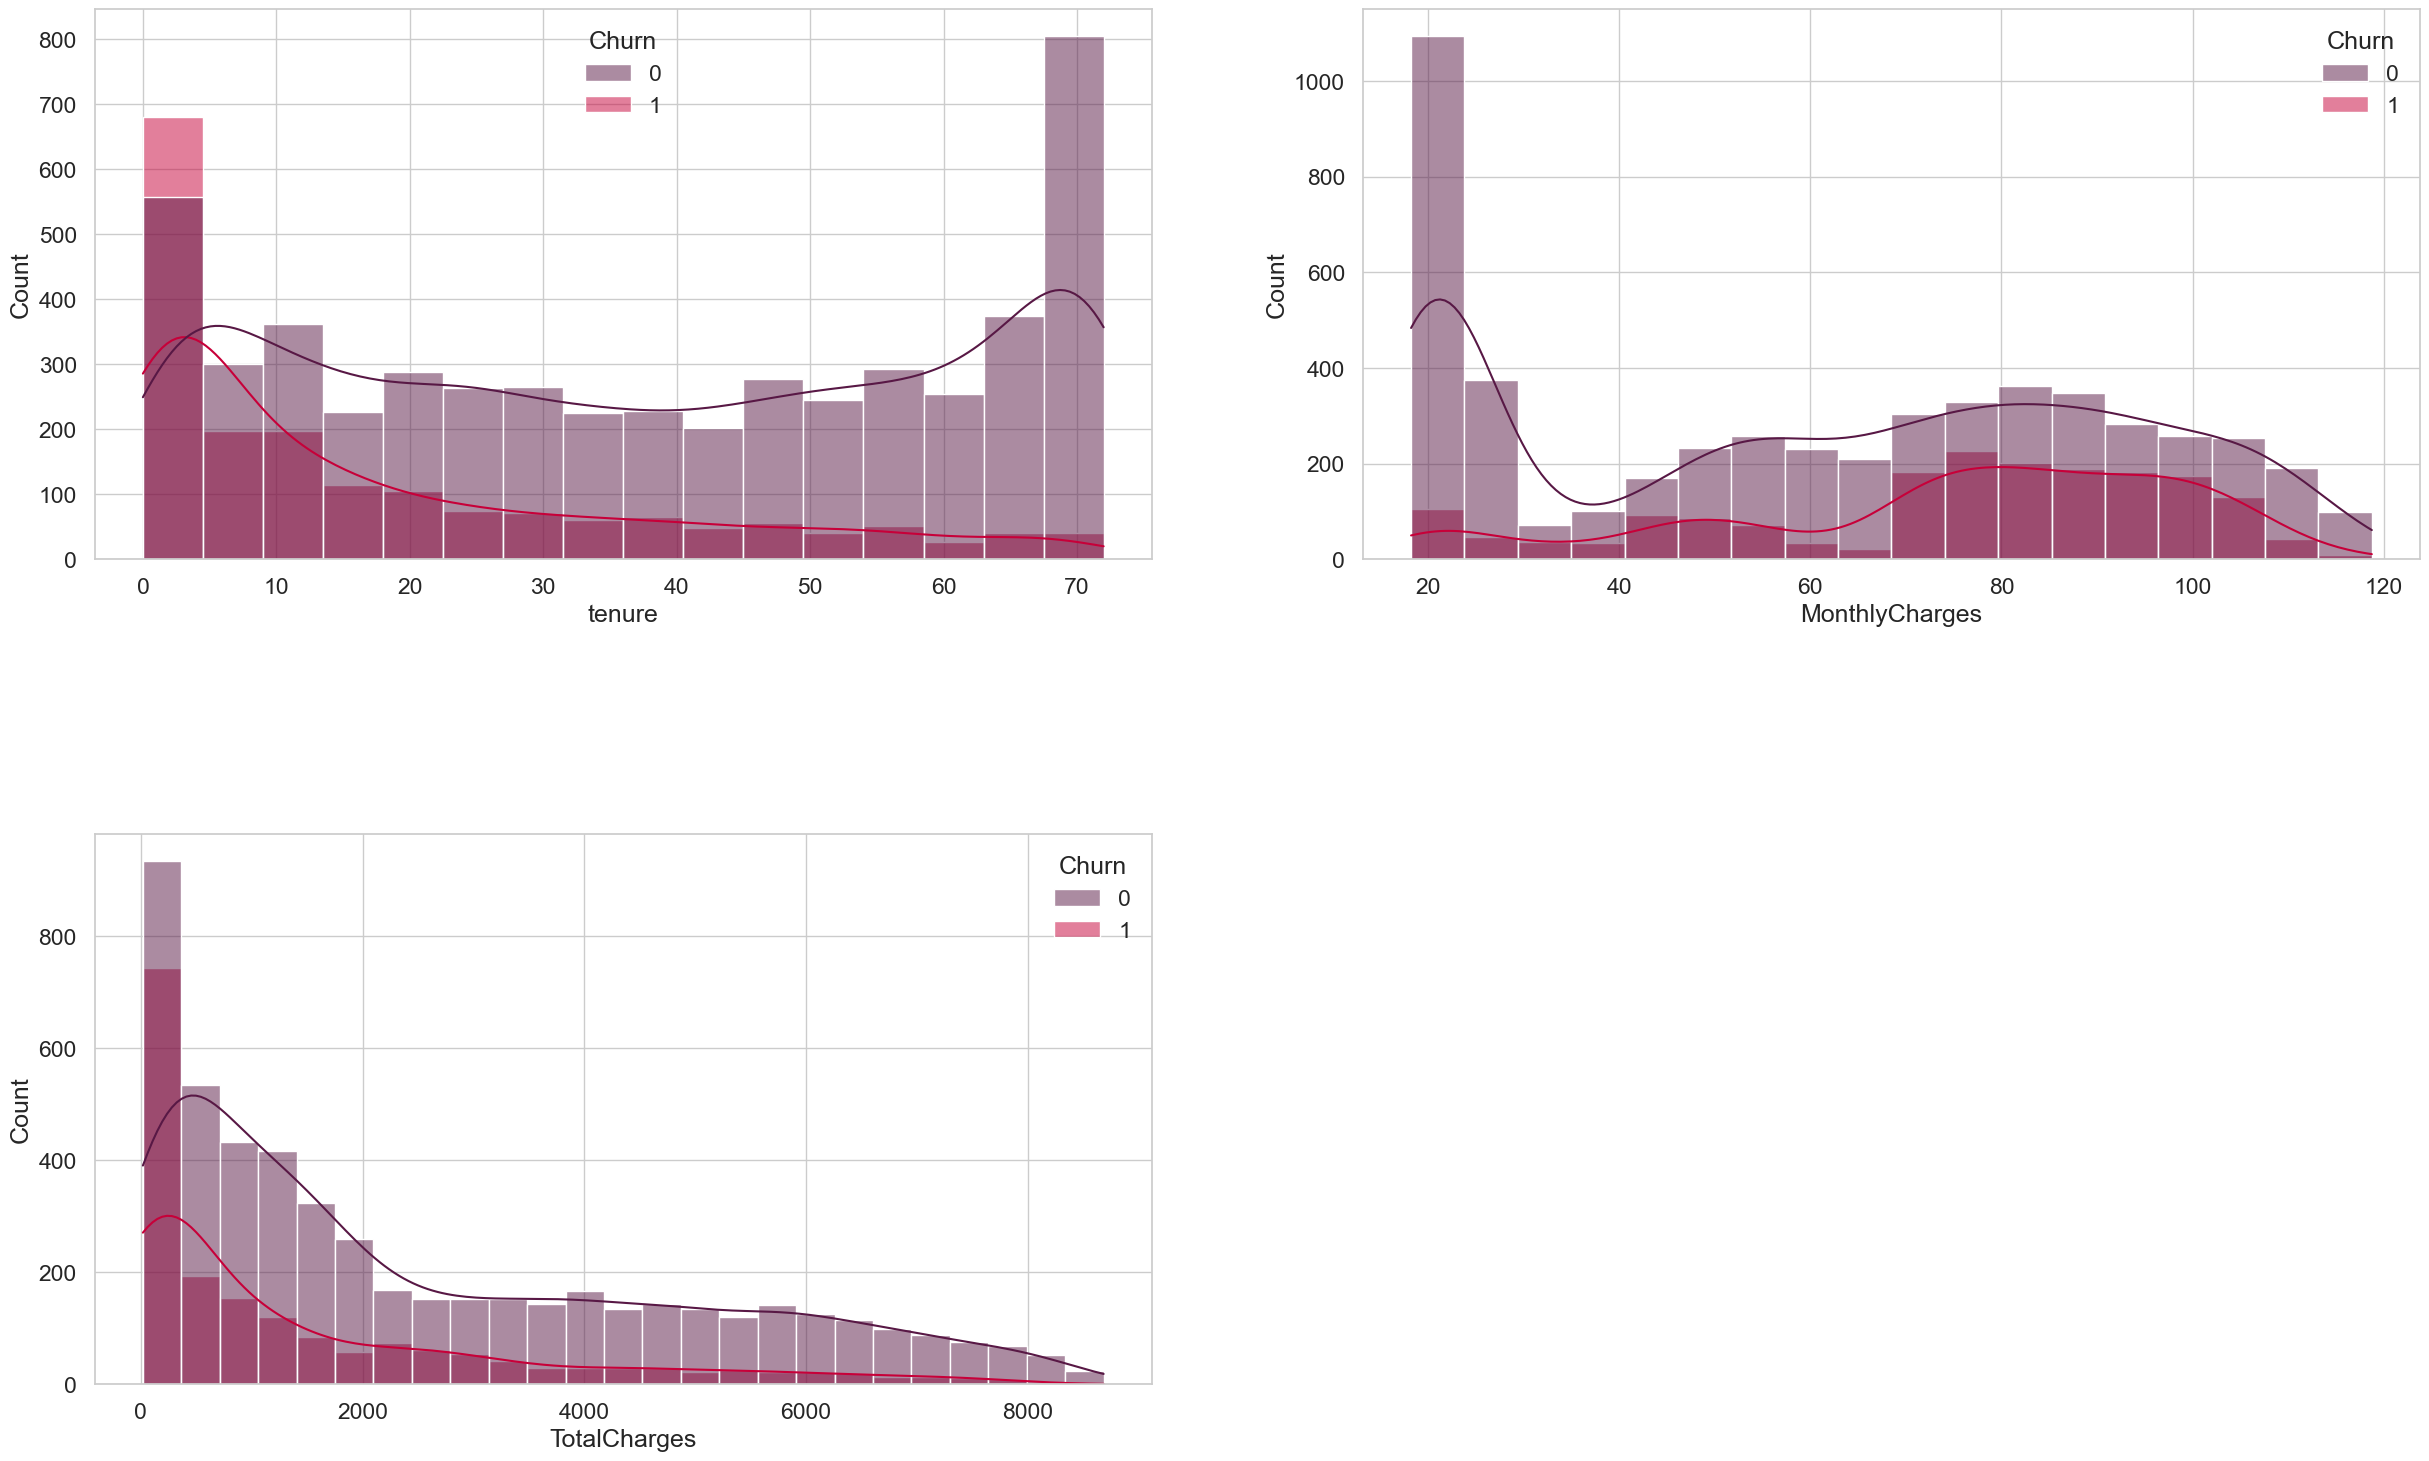

In [10]:
# def num_summary(df, numerical_col, plot=False):
#     quantiles = [0.05, 0.10, 0.20, 0.30, 0.40, 0.50, 0.60, 0.70, 0.80, 0.90, 0.95, 0.99]
#     print(df[numerical_col].describe(quantiles))
#
#     if plot:
#         plt.figure(figsize=(10, 5))
#         # df[numerical_col].hist(bins=20)
#         sns.histplot(df[numerical_col], kde=True)
#         plt.show()
#
#
# for col in num_cols:
#     num_summary(df, col, plot=True)


def num_features_hist(df, column_name, i, hue):
    rcParams['figure.figsize'] = 30, 50
    sns.set(font_scale=1.5)
    sns.set_style("whitegrid")
    sns.set_palette("bright")
    plt.subplots_adjust(hspace=0.5)
    plt.subplot(5, 2, i)
    sns.histplot(data=df, x=column_name, hue=hue,
                 kde=True, palette=constraints)


def num_summary(df, column_name):
    fig = make_subplots(rows=1, cols=2,
                        subplot_titles=('Quantiles', 'Distribution'))

    fig.add_trace(go.Box(y=df[column_name],
                         name=str(column_name),
                         showlegend=False,
                         boxpoints="outliers",
                         marker_color=constraints[1]),
                  row=1, col=1,)

    fig.add_trace(go.Histogram(x=df[column_name],
                               xbins=dict(start=df[column_name].min(),
                                          end=df[column_name].max()),
                               showlegend=False,
                               name=str(column_name),
                               marker=dict(color=constraints[0],
                                           line=dict(color='#DBE6EC',
                                                     width=1))),
                  row=1, col=2)

    fig.update_layout(title={'text': column_name,
                             'y': 0.9,
                             'x': 0.5,
                             'xanchor': 'center',
                             'yanchor': 'top'},
                      template='plotly_white')

    iplot(fig)


i = 0
for column_name in num_cols:
    i = i + 1
    num_summary(df, column_name)
    num_features_hist(df, column_name, i, hue='Churn')

In [11]:
# def cat_summary(df, col_name, plot=False):
#     print(pd.DataFrame({col_name: df[col_name].value_counts(),
#                         "Ratio": 100 * df[col_name].value_counts() / len(df)}))
#     print("##########################################")
#     if plot:
#         sns.countplot(x=df[col_name], data=df)
#         plt.show()
# 
# 
# for col in cat_cols:
#     cat_summary(df, col, plot=True)


def categorical_variable_summary(df, column_name):
    fig = make_subplots(rows=1, cols=2,
                        subplot_titles=('Countplot', 'Percentages'),
                        specs=[[{"type": "xy"}, {'type': 'domain'}]])

    fig.add_trace(go.Bar(y=df[column_name].value_counts().values.tolist(),
                         x=[str(i) for i in df[column_name].value_counts().index],
                         text=df[column_name].value_counts().values.tolist(),
                         textfont=dict(size=15),
                         name=column_name,
                         textposition='auto',
                         showlegend=False,
                         marker=dict(color=cat_feat_constraints,
                                     line=dict(color='#DBE6EC',
                                               width=1))),
                  row=1, col=1)

    fig.add_trace(go.Pie(labels=df[column_name].value_counts().keys(),
                         values=df[column_name].value_counts().values,
                         textfont=dict(size=20),
                         textposition='auto',
                         showlegend=False,
                         name=column_name,
                         marker=dict(colors=cat_feat_constraints)),
                  row=1, col=2)

    fig.update_layout(title={'text': column_name,
                             'y': 0.9,
                             'x': 0.5,
                             'xanchor': 'center',
                             'yanchor': 'top'},
                      template='plotly_white')

    iplot(fig)


for cat in cat_cols:
    categorical_variable_summary(df, cat)

## Adım 4: Kategorik değişkenler ile hedef değişken incelemesini yapınız.

In [12]:
# Hedef değişken analizi

# Kategorik değişkenlerin target değişkene göre analizi
def target_summary_with_cat(df, target, categorical_col):
    print(pd.DataFrame({
        "Target_Mean": df.groupby(categorical_col)[target].mean(),
        "Count": df[categorical_col].value_counts(),
        "Ratio": 100 * df[categorical_col].value_counts() / len(df)
    }))
    print("#" * 50)


for col in cat_cols:
    target_summary_with_cat(df, "Churn", col)

        Target_Mean  Count    Ratio
gender                             
Female      0.26921   3488 49.52435
Male        0.26160   3555 50.47565
##################################################
         Target_Mean  Count    Ratio
Partner                             
No           0.32958   3641 51.69672
Yes          0.19665   3402 48.30328
##################################################
            Target_Mean  Count    Ratio
Dependents                             
No              0.31279   4933 70.04118
Yes             0.15450   2110 29.95882
##################################################
              Target_Mean  Count    Ratio
PhoneService                             
No                0.24927    682  9.68337
Yes               0.26710   6361 90.31663
##################################################
                  Target_Mean  Count    Ratio
MultipleLines                                
No                    0.25044   3390 48.13290
No phone service      0.24927    682  

In [13]:
# Numerik değişkenlerin target değişkenine göre analizi

def target_summary_with_num(df, target, numerical_col):
    print(df.groupby(target).agg({numerical_col: "mean"}))
    print("#" * 50)


for col in num_cols:
    target_summary_with_num(df, "Churn", col)

        tenure
Churn         
0     37.56997
1     17.97913
##################################################
       MonthlyCharges
Churn                
0            61.26512
1            74.44133
##################################################
       TotalCharges
Churn              
0        2555.34414
1        1531.79609
##################################################


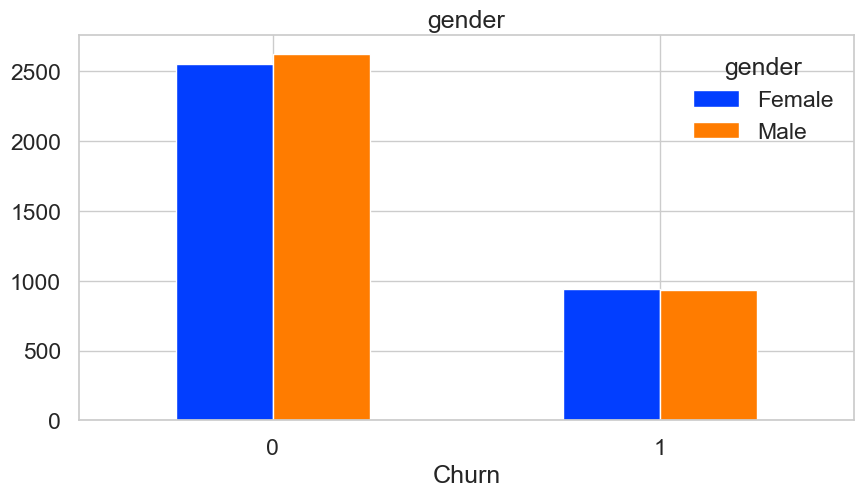

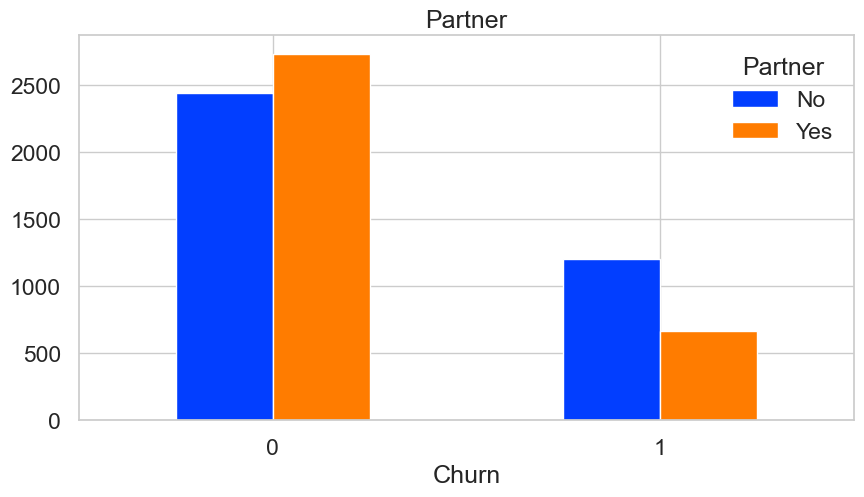

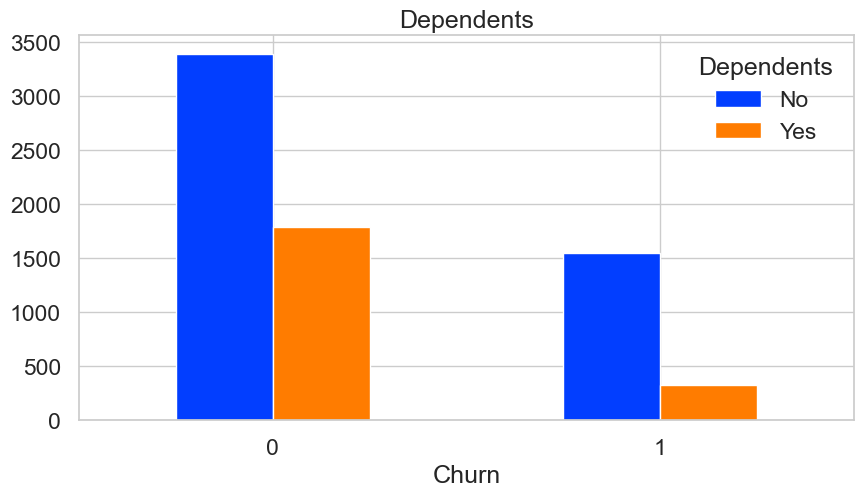

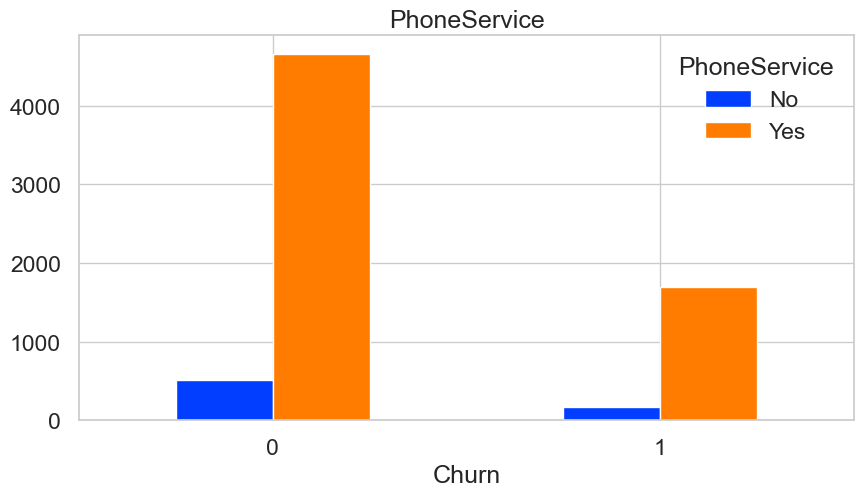

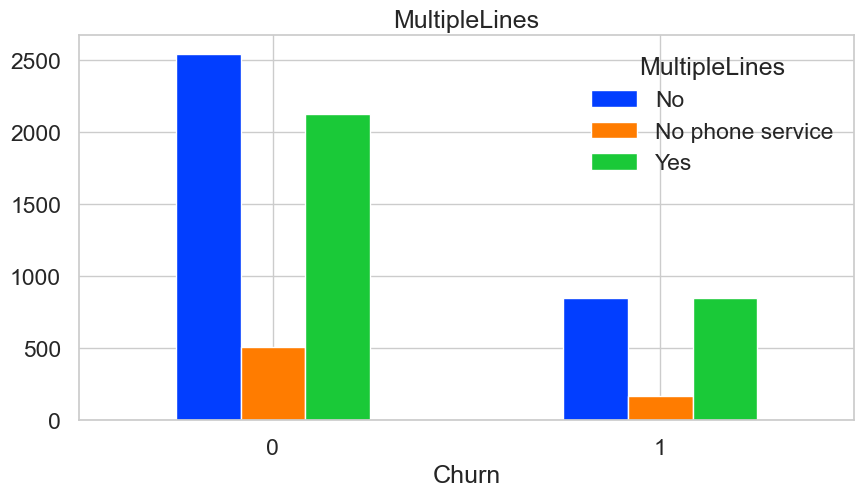

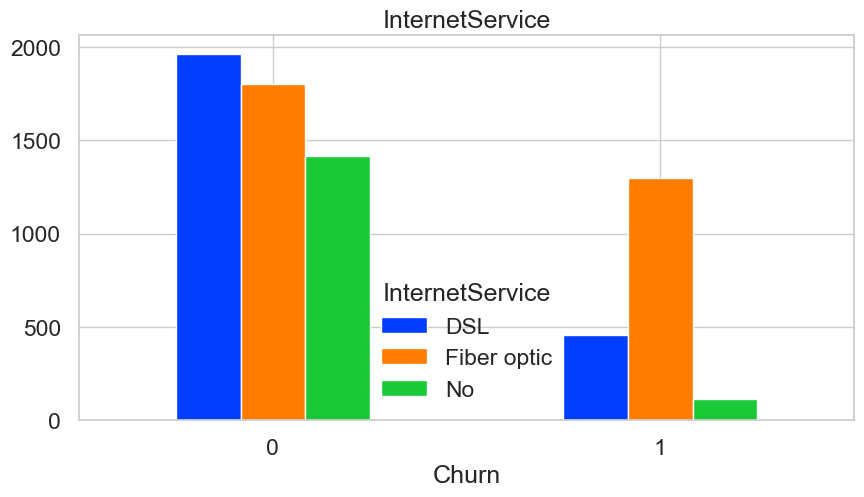

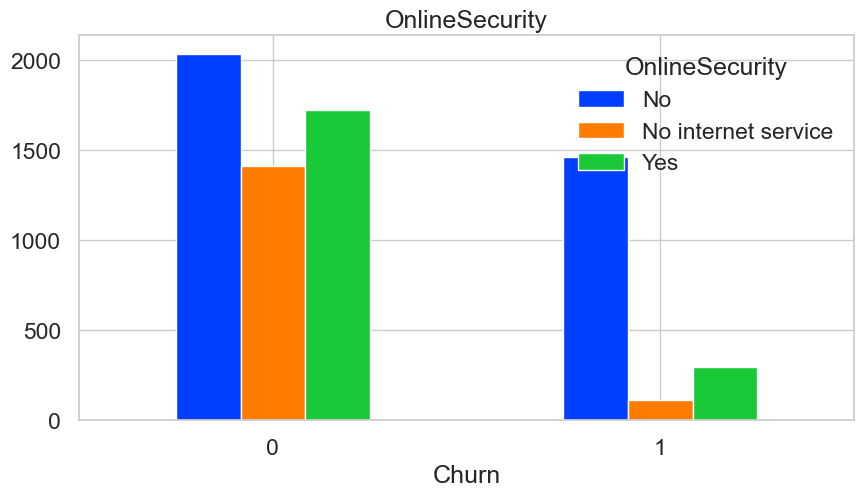

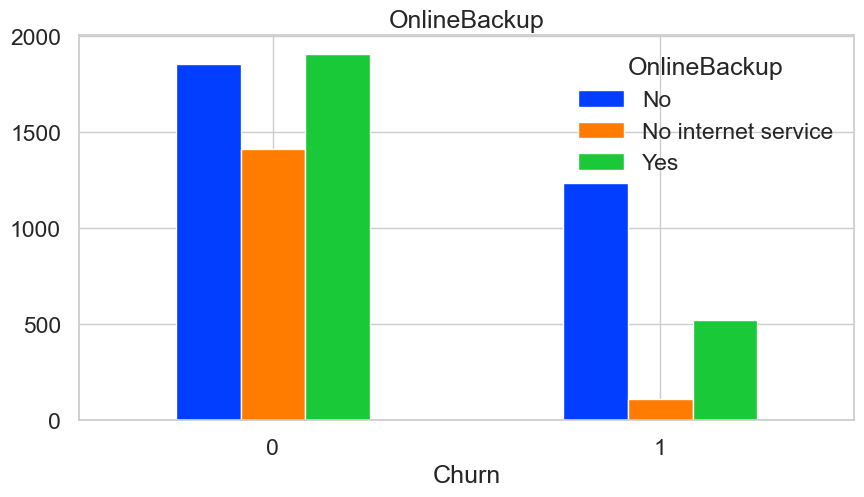

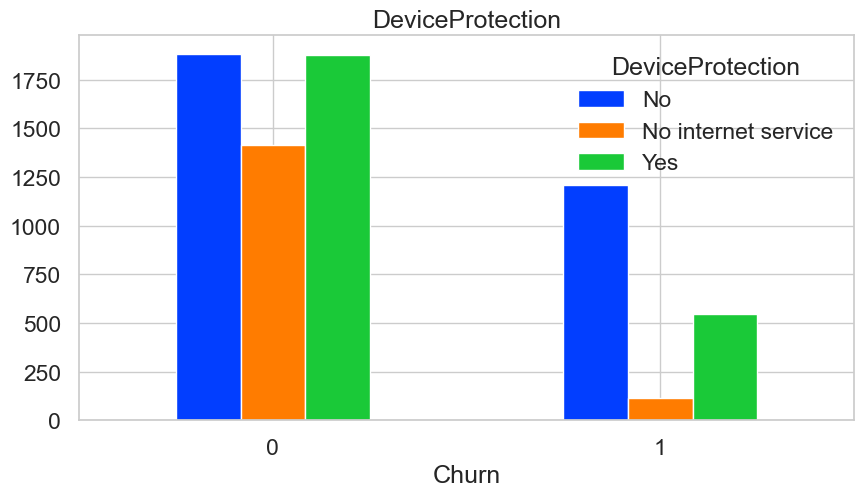

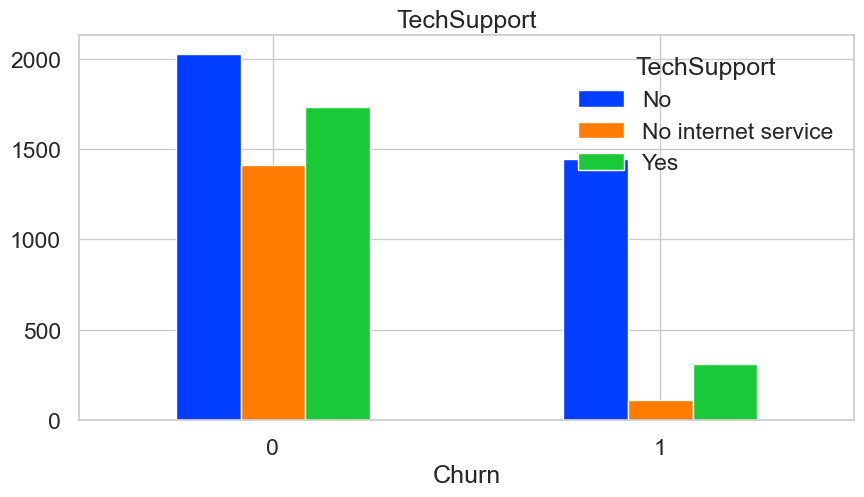

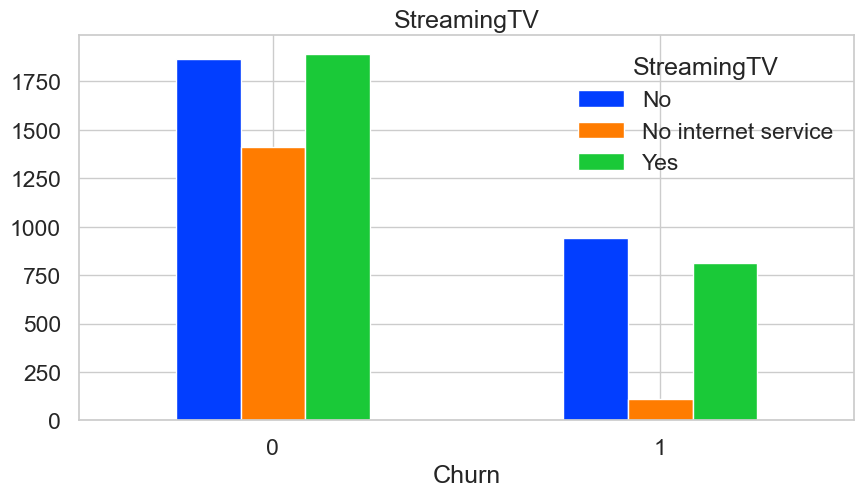

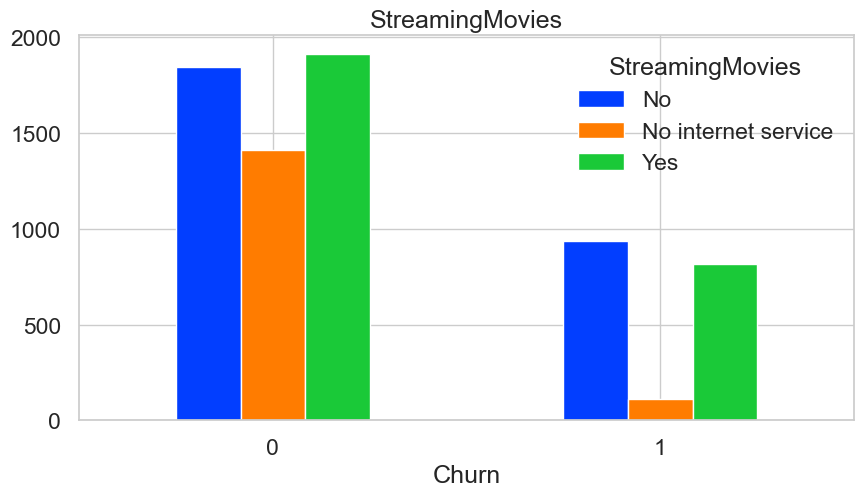

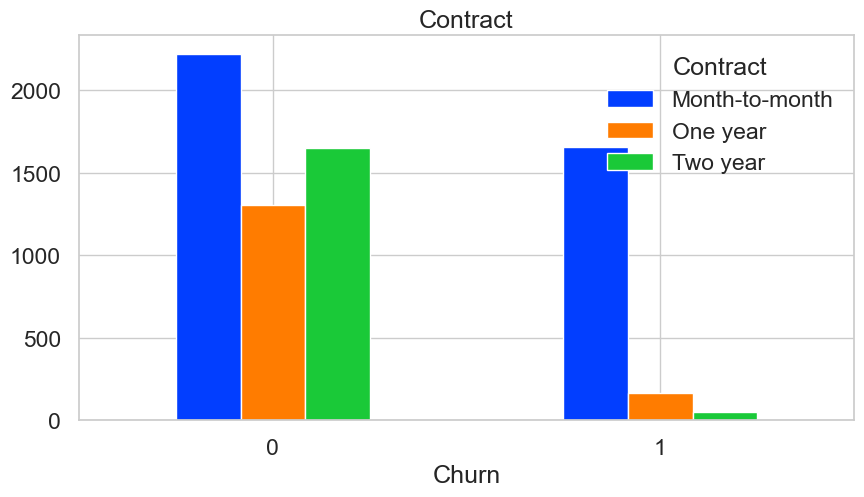

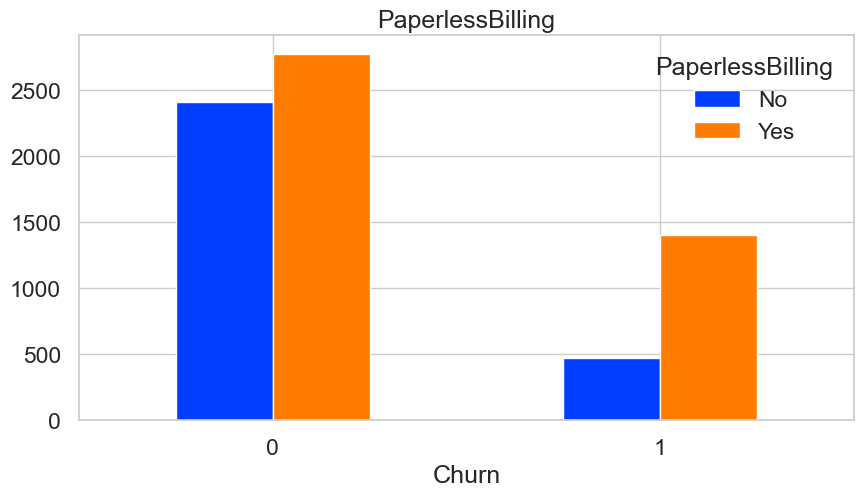

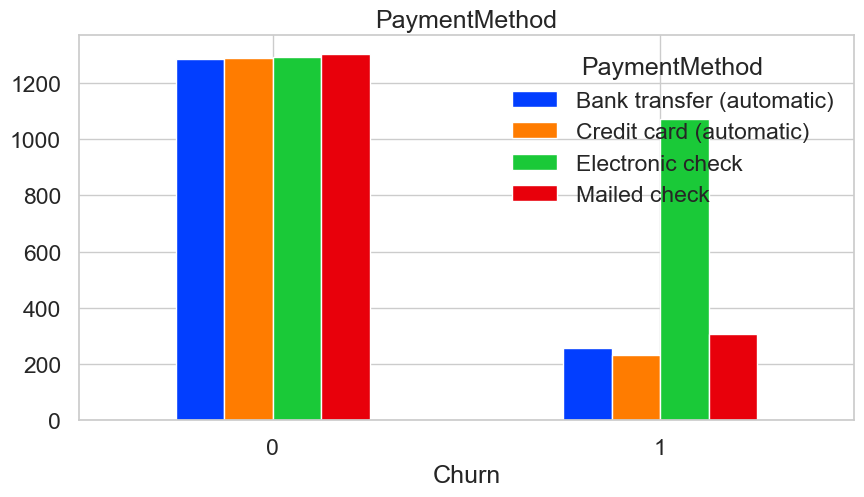

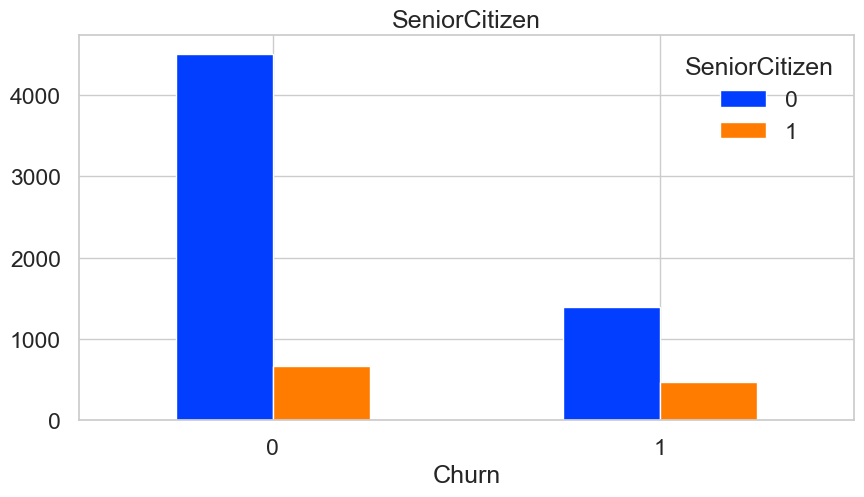

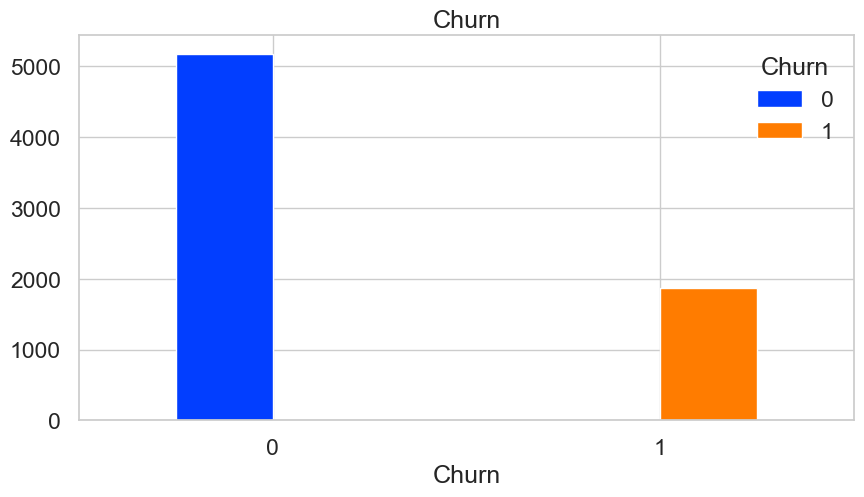

In [14]:
# churn değişkenine bağlı olarak kategorik değişken görselleştirme
for col in cat_cols:
    graph = pd.crosstab(index=df['Churn'], columns=df[col]).plot.bar(figsize=(10, 5), rot=0)
    plt.title(col)
    plt.show()

## Adım 5: Aykırı gözlem var mı inceleyiniz.

In [15]:
def outlier_thresholds(dataframe, col, low_quantile=0.07, up_quantile=0.93):

    quantile_one = dataframe[col].quantile(low_quantile)
    quantile_three = dataframe[col].quantile(up_quantile)

    interquantile_range = quantile_three - quantile_one
    up_limit = quantile_three + 1.5 * interquantile_range
    low_limit = quantile_one - 1.5 * interquantile_range

    return low_limit, up_limit


def check_outlier(dataframe, col_name):
    low_limit, up_limit = outlier_thresholds(dataframe, col_name)
    if dataframe[(dataframe[col_name] > up_limit) | (dataframe[col_name] < low_limit)].any(axis=None):
        return True, len(dataframe[(dataframe[col_name] > up_limit) | (dataframe[col_name] < low_limit)]);
    else:
        return False


for col in num_cols:
    print(f"{col}, outlier detection is {check_outlier(df, col)}")


tenure, outlier detection is False
MonthlyCharges, outlier detection is False
TotalCharges, outlier detection is False


In [16]:
def check_outliers(dataframe):
    outliers_exist = False
    for col in dataframe.columns:
        if dataframe[col].dtypes not in ['object', 'category']:
            q1_val = dataframe[col].quantile(0.07)
            q3_val = dataframe[col].quantile(0.93)
            iqr = q3_val - q1_val
            lower_bound = q1_val - 1.5 * iqr
            upper_bound = q3_val + 1.5 * iqr
            outliers = dataframe[(dataframe[col] < lower_bound) | (dataframe[col] > upper_bound)]
            if not outliers.empty:
                print(f"Outliers detected! Column: {col}")
                outliers_exist = True
    if not outliers_exist:
        print("No outliers detected.")
        
check_outliers(df)

No outliers detected.


## Adım 6: Eksik gözlem var mı inceleyiniz.

In [17]:
def check_missing_value(dataframe, na_name=False):
    na_columns = [
        col for col in dataframe.columns if dataframe[col].isnull().sum() > 0]
    n_miss = dataframe[na_columns].isnull().sum().sort_values(ascending=False)
    ratio = (dataframe[na_columns].isnull().sum() /
             dataframe.shape[0] * 100).sort_values(ascending=False)
    missing_df = pd.concat([n_miss, np.round(ratio, 2)],
                           axis=1, keys=['n_miss', 'ratio'])
    print(missing_df, end="\n")

    if na_name:
        return na_columns


def missing_vs_target(dataframe, target, na_columns):
    temp_df = dataframe.copy()

    for col in na_columns:
        temp_df[col + '_NA_FLAG'] = np.where(temp_df[col].isnull(), 1, 0)

    na_flags = temp_df.loc[:, temp_df.columns.str.contains("_NA_")].columns

    for col in na_flags:
        display(pd.DataFrame({"TARGET_MEAN": temp_df.groupby(col)[target].mean(),
                              "Count": temp_df.groupby(col)[target].count()}))


na_columns = check_missing_value(df, na_name=True)
missing_vs_target(df, 'Churn', na_columns)

              n_miss   ratio
TotalCharges      11 0.16000


,TARGET_MEAN,Count
TotalCharges_NA_FLAG,,
0,0.26578,7032
1,0.00000,11


# Görev 2 : Feature Engineering

## Adım 1: Eksik ve aykırı gözlemler için gerekli işlemleri yapınız.

In [18]:
class CorrImputer:
    def __init__(self, target_name, target_values):
        self.target_name = target_name
        self.target_values = target_values
        self.group_medians = {}
    def fit(self, data):
        for col in data.columns:
            if col != self.target_name:
                self.group_medians[col] = data.groupby(self.target_values)[col].transform('median')
    def transform(self, data):
        for col in data.columns:
            if col != self.target_name and col in self.group_medians:
                data[col].fillna(self.group_medians[col], inplace=True)

        return data
    def fit_transform(self, data):
        self.fit(data)
        return self.transform(data)

In [19]:
def best_imputation_method(data, target_column):
    missing_values = data.isnull().sum()
    missing_percent = (missing_values / len(data)) * 100
    missing_columns = missing_values[missing_values > 0].index.tolist()
    numeric_columns = data.select_dtypes(include=[np.number]).columns.tolist()

    imputation_methods = {
        "Mean": SimpleImputer(strategy="mean"),
        "Median": SimpleImputer(strategy="median"),
        "Most Frequent": SimpleImputer(strategy="most_frequent"),
        "KNN": KNNImputer(n_neighbors=5),
        "Iterative": IterativeImputer(max_iter=10, random_state=0),
        'CorrImputer': CorrImputer('Churn', df['Churn'])
    }

    results = {}
    for column in missing_columns:
        if column in numeric_columns:
            for method_name, method in imputation_methods.items():
                missing_data = data[data[column].isnull()]

                imputed_data = data.copy()
                imputed_data[column] = method.fit_transform(imputed_data[[column]])

                performance_metric = abs(imputed_data[target_column].corr(imputed_data[column]))

                results[f"{column} - {method_name}"] = performance_metric

    variables = set([col.split(" - ")[0] for col in results.keys()])
    best_methods = {}
    for variable in variables:
        variable_results = {key: value for key, value in results.items() if key.startswith(variable)}

        best_method = max(variable_results, key=variable_results.get)
        best_methods[variable] = best_method.split(" - ")[1]
    return best_methods, imputation_methods

def impute_nulls(data, target_column):
    # data = data.copy()
    best_methods, imputation_methods = best_imputation_method(data, target_column)
    print(best_methods)
    for column, method in best_methods.items():
        data[column] = imputation_methods[method].fit_transform(data[[column]])

target_column = "Churn"
impute_nulls(df, target_column)


{'TotalCharges': 'Mean'}


In [20]:
class CFG:
    outlier_clipper = True
    outlier_remover = False
    outlier_replacer = False
    
    one_hot_encoder = True
    label_encoder = True
    ordinal_encoder = False
    
    min_max_scaler = False
    robust_scaler = False
    standard_scaler = False

In [21]:
class DataProcessor:
    def __init__(self, cfg):
        self.cfg = cfg

    def process_data(self, dataframe):
        if self.cfg.outlier_clipper:
            for col in dataframe.columns:
                if dataframe[col].dtypes not in ['object', 'category']:
                    q1_val = dataframe[col].quantile(0.07)
                    q3_val = dataframe[col].quantile(0.93)
                    dataframe.loc[:, col] = dataframe[col].clip(
                        lower=q1_val, upper=q3_val)

        if self.cfg.outlier_remover:
            for col in dataframe.columns:
                if dataframe[col].dtypes not in ['object', 'category']:
                    q1_val = dataframe[col].quantile(0.07)
                    q3_val = dataframe[col].quantile(0.93)
                    dataframe = dataframe.loc[(dataframe[col] >= q1_val) & (
                        processed_data[col] <= q3_val)]

        if self.cfg.outlier_replacer:
            for col in dataframe.columns:
                if dataframe[col].dtypes not in ['object', 'category']:
                    median_val = dataframe[col].median()
                    dataframe[col] = dataframe[col].where(
                        (dataframe[col] >= q1_val) & (dataframe[col] <= q3_val), median_val)

        return dataframe


data_processor = DataProcessor(CFG())
df = data_processor.process_data(df)

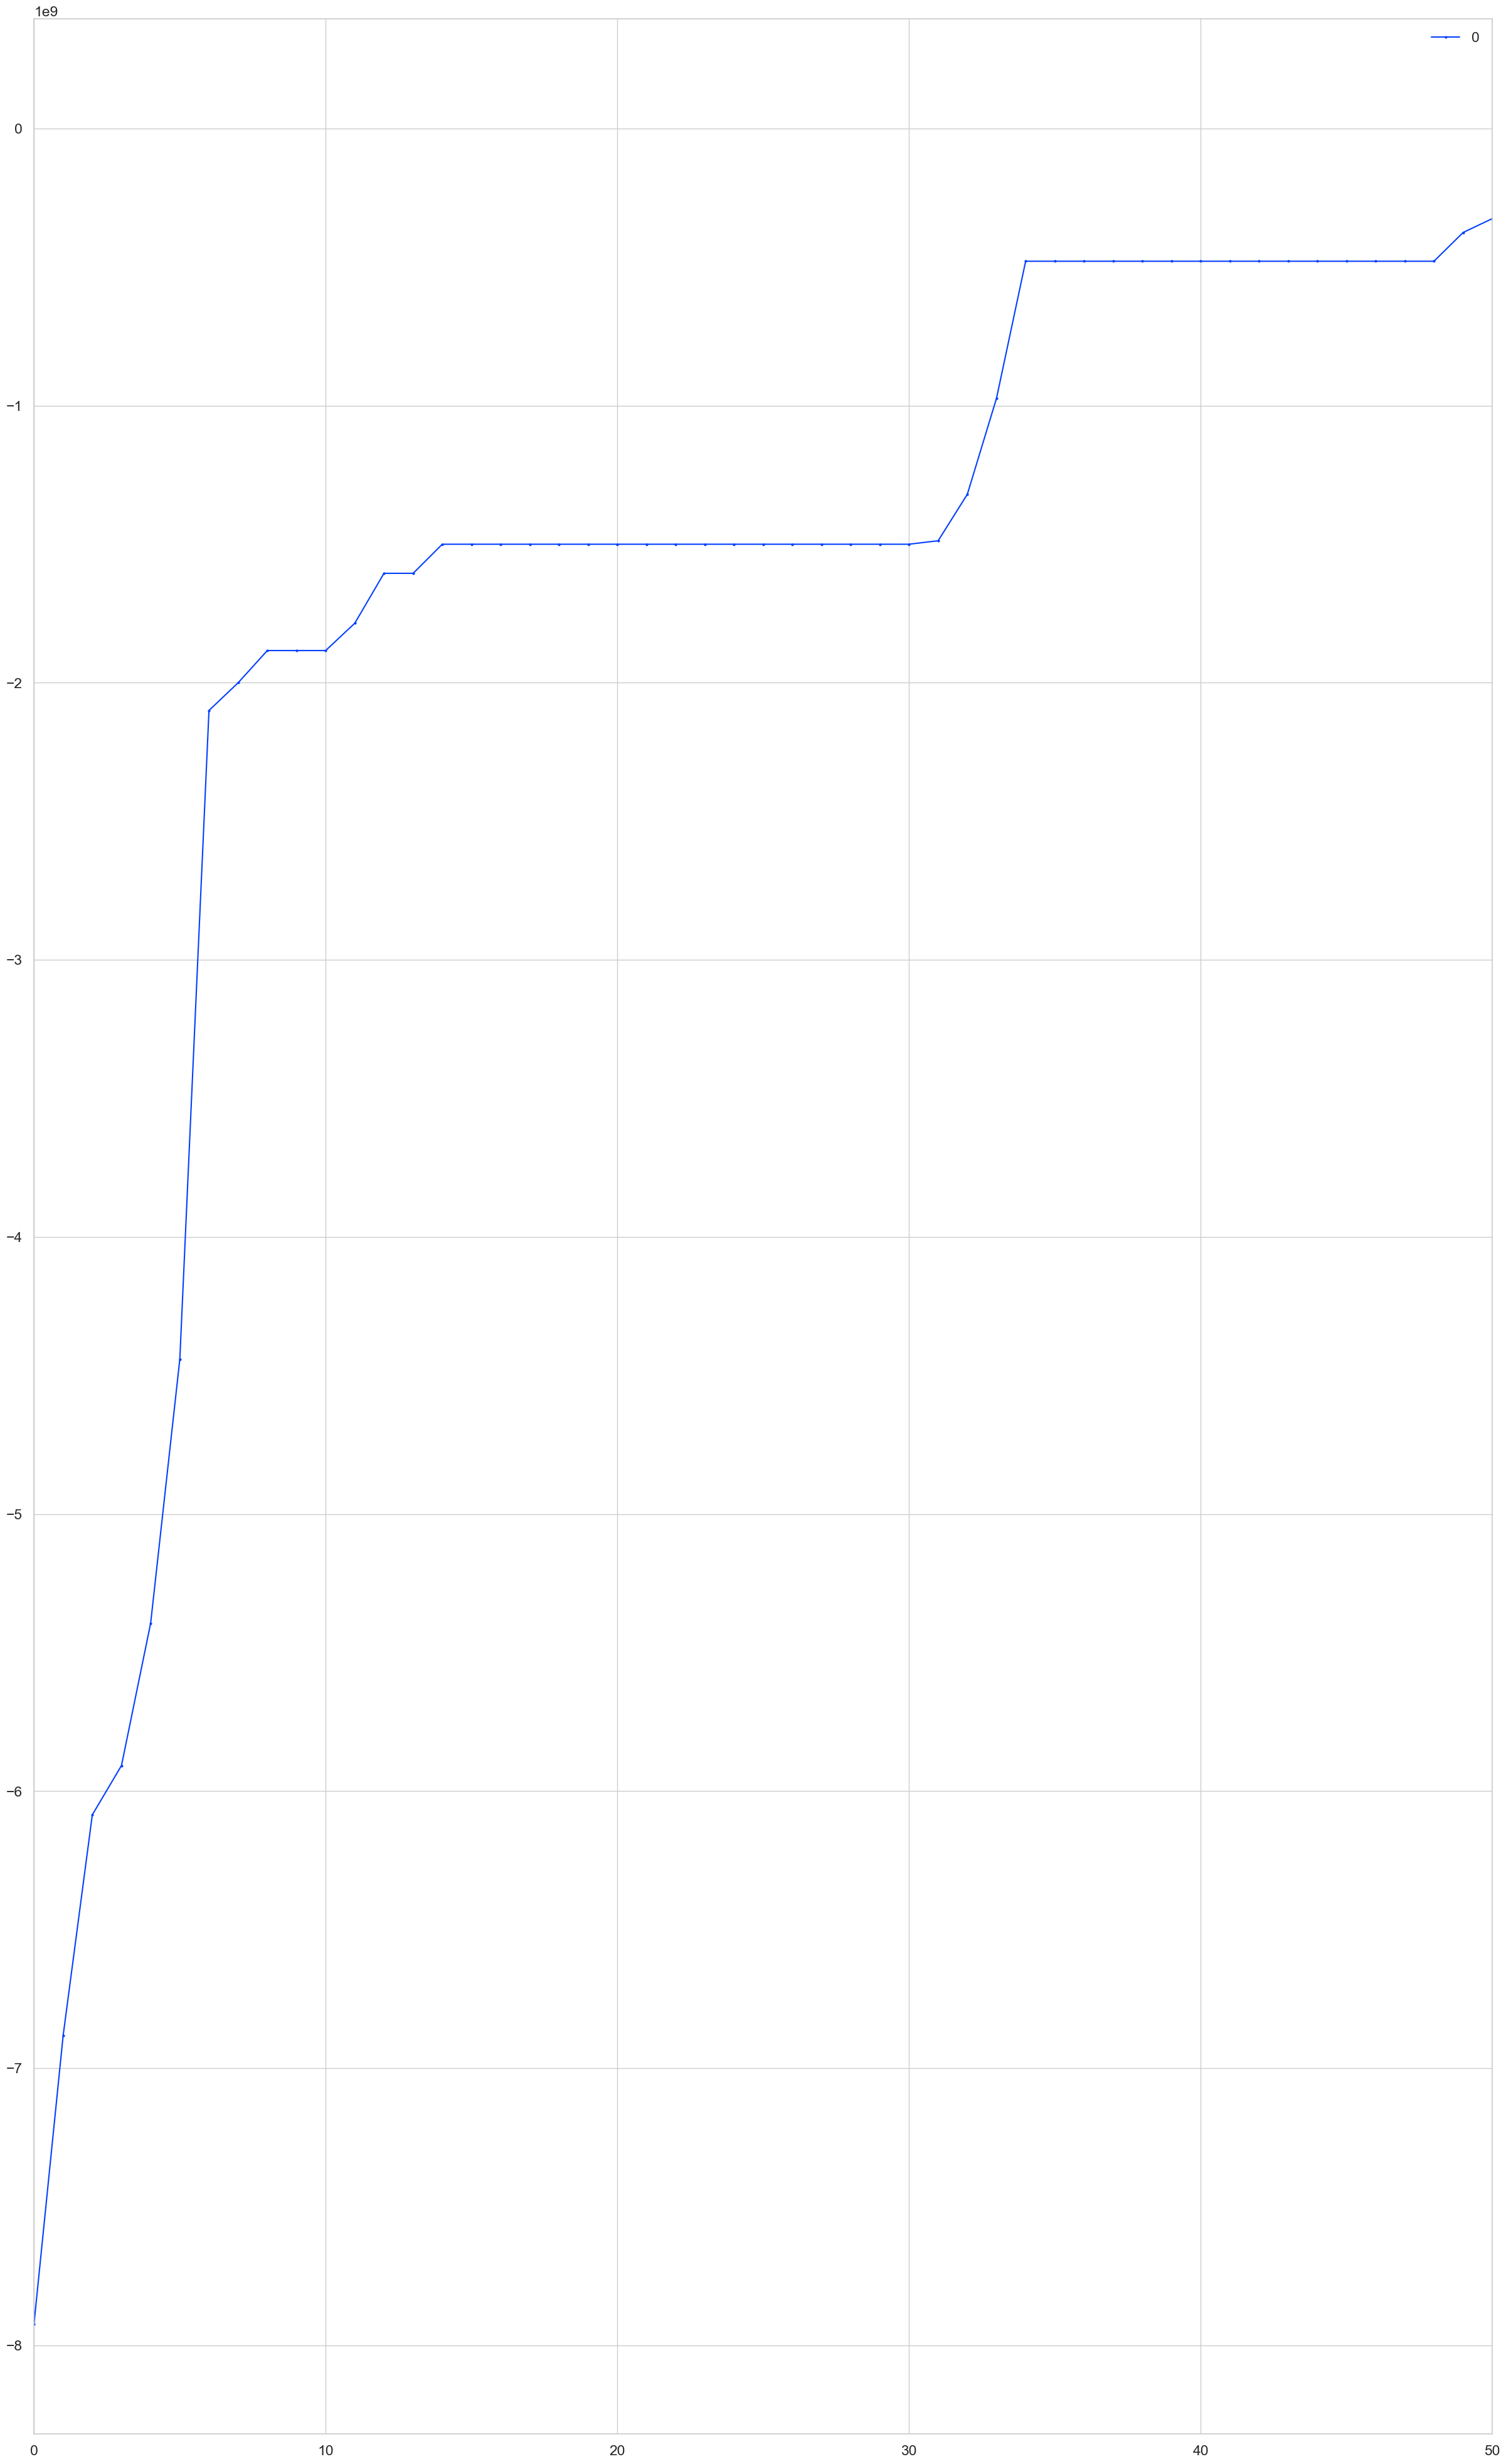

In [22]:
clf = LocalOutlierFactor(n_neighbors=20)
clf.fit_predict(df[num_cols])
df_scores = clf.negative_outlier_factor_
scores = pd.DataFrame(np.sort(df_scores))
scores.plot(stacked=True, xlim=[0, 50], style='.-')
plt.show()

In [23]:
th = np.sort(df_scores)[5]
df[df_scores < th].index
# df[df_scores < th].drop(axis=0, labels=df[df_scores < th].index, inplace=True)

Index([2228, 1949, 6334, 6278, 2019], dtype='int64')

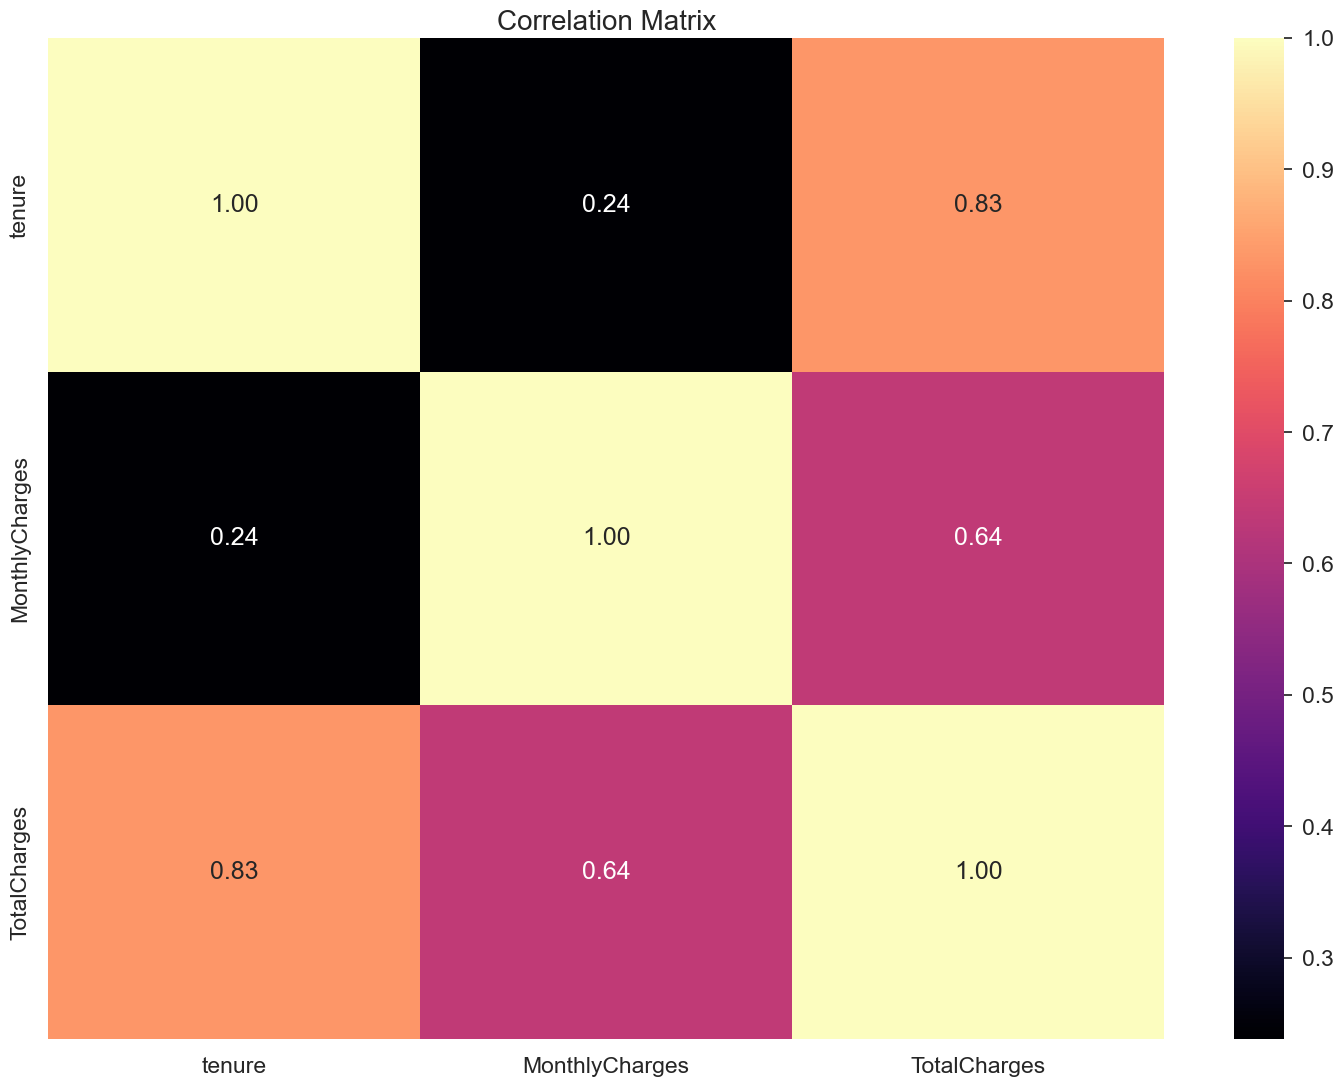

In [24]:
# Korelasyon Matrisi
f, ax = plt.subplots(figsize=[18, 13])
sns.heatmap(df[num_cols].corr(), annot=True, fmt=".2f", ax=ax, cmap="magma")
ax.set_title("Correlation Matrix", fontsize=20)
plt.show()

In [25]:
df[num_cols].corrwith(df["Churn"]).sort_values(ascending=False)

MonthlyCharges    0.19945
TotalCharges     -0.20098
tenure           -0.35229
dtype: float64

In [26]:
from IPython.display import display #I assume you are in a notebook

for i in [col for col in cat_cols if col != "Churn"]:
    my = pd.crosstab(df.Churn, df[i], margins=True).style.background_gradient(cmap='summer_r')
    display(my)

gender,Female,Male,All
Churn,,,
0,2549,2625,5174
1,939,930,1869
All,3488,3555,7043


Partner,No,Yes,All
Churn,,,
0,2441,2733,5174
1,1200,669,1869
All,3641,3402,7043


Dependents,No,Yes,All
Churn,,,
0,3390,1784,5174
1,1543,326,1869
All,4933,2110,7043


PhoneService,No,Yes,All
Churn,,,
0,512,4662,5174
1,170,1699,1869
All,682,6361,7043


MultipleLines,No,No phone service,Yes,All
Churn,,,,
0,2541,512,2121,5174
1,849,170,850,1869
All,3390,682,2971,7043


InternetService,DSL,Fiber optic,No,All
Churn,,,,
0,1962,1799,1413,5174
1,459,1297,113,1869
All,2421,3096,1526,7043


OnlineSecurity,No,No internet service,Yes,All
Churn,,,,
0,2037,1413,1724,5174
1,1461,113,295,1869
All,3498,1526,2019,7043


OnlineBackup,No,No internet service,Yes,All
Churn,,,,
0,1855,1413,1906,5174
1,1233,113,523,1869
All,3088,1526,2429,7043


DeviceProtection,No,No internet service,Yes,All
Churn,,,,
0,1884,1413,1877,5174
1,1211,113,545,1869
All,3095,1526,2422,7043


TechSupport,No,No internet service,Yes,All
Churn,,,,
0,2027,1413,1734,5174
1,1446,113,310,1869
All,3473,1526,2044,7043


StreamingTV,No,No internet service,Yes,All
Churn,,,,
0,1868,1413,1893,5174
1,942,113,814,1869
All,2810,1526,2707,7043


StreamingMovies,No,No internet service,Yes,All
Churn,,,,
0,1847,1413,1914,5174
1,938,113,818,1869
All,2785,1526,2732,7043


Contract,Month-to-month,One year,Two year,All
Churn,,,,
0,2220,1307,1647,5174
1,1655,166,48,1869
All,3875,1473,1695,7043


PaperlessBilling,No,Yes,All
Churn,,,
0,2403,2771,5174
1,469,1400,1869
All,2872,4171,7043


PaymentMethod,Bank transfer (automatic),Credit card (automatic),Electronic check,Mailed check,All
Churn,,,,,
0,1286,1290,1294,1304,5174
1,258,232,1071,308,1869
All,1544,1522,2365,1612,7043


SeniorCitizen,0,1,All
Churn,,,
0,4508,666,5174
1,1393,476,1869
All,5901,1142,7043


## Adım 2: Yeni değişkenler oluşturunuz.

In [27]:
def categorize_tenure(tenure):
    if tenure <= 12:
        return 'Short-Term'
    elif tenure > 12 and tenure <= 24:
        return 'Mid-Term'
    else:
        return 'Long-Term'


df['TenureGroup'] = df['tenure'].apply(categorize_tenure)

df['HasInternetService'] = df['InternetService'].apply(lambda x: 'Yes' if x != 'No' else 'No')
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'])


def categorize_family_size(partner, dependents):
    if partner == 'No' and dependents == 'Yes':
        return 'Family'
    elif partner == 'Yes' or dependents == 'Yes':
        return 'Couple'
    else:
        return 'Single'


df['FamilySize'] = df.apply(lambda x: categorize_family_size(x['Partner'], x['Dependents']), axis=1)

df['AvgMonthlyChargesPerTenure'] = df['TotalCharges'] / df['tenure']

df["MonthlyByTotal"] = df['MonthlyCharges'] / df['TotalCharges']


def categorize_monthly_charges(charges):
    if charges < 50:
        return 'Low Charges'
    elif charges >= 50 and charges < 100:
        return 'Moderate Charges'
    else:
        return 'High Charges'


df['MonthlyChargesCategory'] = df['MonthlyCharges'].apply(categorize_monthly_charges)


def bundled_streaming_services(tv, movies):
    if tv == 'Yes' and movies == 'Yes':
        return 'Bundled Streaming'
    else:
        return 'No Streaming Bundle'


df['StreamingServicesBundled'] = df.apply(lambda x: bundled_streaming_services(x['StreamingTV'], x['StreamingMovies']),
                                          axis=1)


def multiple_services_used(df):
    count = 0
    if df['PhoneService'] == 'Yes':
        count += 1
    if df['InternetService'] != 'No':
        count += 1
    if df['MultipleLines'] == 'Yes':
        count += 1
    if df['OnlineSecurity'] == 'Yes':
        count += 1
    if df['OnlineBackup'] == 'Yes':
        count += 1
    if df['DeviceProtection'] == 'Yes':
        count += 1
    if df['TechSupport'] == 'Yes':
        count += 1
    if df['StreamingTV'] == 'Yes':
        count += 1
    if df['StreamingMovies'] == 'Yes':
        count += 1

    return count


df['MultipleServicesUsed'] = df.apply(multiple_services_used, axis=1)

## Adım 3: Encoding işlemlerini gerçekleştiriniz.


In [28]:
class DataProcessorEncode:
    def __init__(self, cfg):
        self.cfg = cfg

    def encode_data(self, dataframe):
        if self.cfg.one_hot_encoder:
            # object_cols = dataframe.select_dtypes(include=['object', 'category']).columns
            object_cols = [col for col in dataframe.columns if 10 >= dataframe[col].nunique() > 2]

            if len(object_cols) > 0:
                dataframe = pd.get_dummies(dataframe, columns=object_cols, drop_first=True, dtype=int)
                print("One-hot encoding applied.")
            else:
                print("Warning: No object or category columns found. One-hot encoding was not applied.")


        if self.cfg.label_encoder:
            label_encoder = LabelEncoder()
            object_cols = [col for col in dataframe.columns if dataframe[col].dtypes in ['object', 'category'] and dataframe[col].nunique() == 2]
            # object_cols = dataframe.select_dtypes(include=['object', 'category']).columns
            if len(object_cols) > 0:
                for col in object_cols:
                    dataframe[col] = label_encoder.fit_transform(dataframe[col])
                    print("Label encoding applied.")
            else:
                print("Warning: No object or category columns found. Label encoding was not applied.")
                
        if self.cfg.ordinal_encoder:
            ordinal_encoder = {}  # Boş bir sözlük oluşturuyoruz.
            object_cols = dataframe.select_dtypes(include=['object', 'category']).columns
            if len(object_cols) > 0:
                for col in object_cols:
                    unique_values = sorted(dataframe[col].unique())
                    ordinal_encoder[col] = {value: index for index, value in enumerate(unique_values)}
                    dataframe[col] = dataframe[col].map(ordinal_encoder[col])
                    print("Ordinal encoding applied.")
            else:
                print("Warning: No object or category columns found. Ordinal encoding was not applied.")


        return dataframe

data_processor_encode = DataProcessorEncode(CFG())
df = data_processor_encode.encode_data(df)

One-hot encoding applied.
Label encoding applied.
Label encoding applied.
Label encoding applied.
Label encoding applied.
Label encoding applied.
Label encoding applied.
Label encoding applied.


## Adım 4: Numerik değişkenler için standartlaştırma yapınız.

In [29]:
def select_best_scaler(data, scaler_list, target_variable):
    results = {}

    for scaler in scaler_list:
        transformed_data = scaler.fit_transform(data)
        sample_model = LGBMClassifier()
        sample_model.fit(transformed_data, target_variable)
        accuracy = sample_model.score(transformed_data, target_variable)
        results[scaler] = accuracy

    best_scaler_name = max(results, key=results.get)

    return best_scaler_name

scaler_list = [StandardScaler(), MinMaxScaler(), RobustScaler()]
best_scaler = select_best_scaler(df, scaler_list, df['Churn'])
print("Best scaler:", best_scaler)

# num_cols = df.select_dtypes(include=[int, float]).columns
# df[num_cols] = best_scaler.fit_transform(df[num_cols])
# print(f"{best_scaler} applied.")

if str(best_scaler) == "StandardScaler()":
    CFG.standard_scaler = True
elif str(best_scaler) == "MinMaxScaler()":
    CFG.min_max_scaler = True
elif str(best_scaler) == "RobustScaler()":
    CFG.robust_scaler = True    

Best scaler: MinMaxScaler()


In [30]:
class DataProcessorScaled:
    def __init__(self, cfg):
        self.cfg = cfg

    def scaled_data(self, dataframe):
        if self.cfg.min_max_scaler:
            num_cols = dataframe.select_dtypes(include=['int', 'float']).columns
            if len(num_cols) > 0:
                min_max_scaler = MinMaxScaler()
                dataframe[num_cols] = min_max_scaler.fit_transform(dataframe[num_cols])
                print("Min-Max scaling applied.")
            else:
                print("Warning: No numerical columns found. Min-Max scaling was not applied.")

        if self.cfg.standard_scaler:
            num_cols = dataframe.select_dtypes(include=['int', 'float']).columns
            if len(num_cols) > 0:
                standard_scaler = StandardScaler()
                dataframe[num_cols] = standard_scaler.fit_transform(dataframe[num_cols])
                print("Standard scaling applied.")
            else:
                print("Warning: No numerical columns found. Standard scaling was not applied.")

        if self.cfg.robust_scaler:
            num_cols = dataframe.select_dtypes(include=['int', 'float']).columns
            if len(num_cols) > 0:
                robust_scaler = RobustScaler()
                dataframe[num_cols] = robust_scaler.fit_transform(dataframe[num_cols])
                print("Robust scaling applied.")
            else:
                print("Warning: No numerical columns found. Robust scaling was not applied.")

        return dataframe
    
data_processor_scale = DataProcessorScaled(CFG())
df = data_processor_scale.scaled_data(df)

Min-Max scaling applied.


# Görev 3 : Modelleme

In [31]:
y = df['Churn']
X = df.drop(['Churn'], axis=1)
random_state = 42

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    stratify=y,
                                                    random_state=random_state,
                                                    test_size=0.2,
                                                    shuffle=True)

print(f"The shape of X_train: {colored(X_train.shape,'red')}")
print(f"The shape of X_test: {colored(X_test.shape,'red')}")
print(f"The shape of y_train: {colored(y_train.shape,'red')}")
print(f"The shape of y_test: {colored(y_test.shape,'red')}")

The shape of X_train: (5634, 48)
The shape of X_test: (1409, 48)
The shape of y_train: (5634,)
The shape of y_test: (1409,)


## Adım 1: Sınıflandırma algoritmaları ile modeller kurup, accuracy skorlarını inceleyip. En iyi 4 modeli seçiniz.


In [32]:
metric_res = []
models = []

models.append(("LGBMClassifier", LGBMClassifier(random_state = random_state)))
models.append(('XGBClassifier', XGBClassifier(random_state = random_state)))
models.append(('CatBoostClassifier', CatBoostClassifier(verbose=False, random_state = random_state)))
models.append(('GradientBoostingClassifier', GradientBoostingClassifier(random_state = random_state)))
models.append(('AdaBoostClassifier', AdaBoostClassifier(random_state = random_state)))
models.append(('RandomForestClassifier', RandomForestClassifier(random_state = random_state)))
models.append(('DecisionTreeClassifier', DecisionTreeClassifier(random_state = random_state)))
models.append(('LogisticRegression', LogisticRegression(random_state = random_state)))
models.append(('MLPClassifier', MLPClassifier(random_state = random_state)))
models.append(('KNeighborsClassifier', KNeighborsClassifier()))

In [33]:
def clc_ml(model):

    y_pred = model.fit(X_train, y_train).predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])
    f1 = f1_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    score = model.score(X_test, y_test)

    kfold = KFold(n_splits=10, shuffle=True, random_state = random_state)
    cv_results = cross_val_score(model, X, y, cv=kfold, scoring="accuracy")
    cv_mean = cv_results.mean()

    mt_dataframe = pd.DataFrame({'Scores': [accuracy, score, cv_mean, f1, precision, recall, roc_auc],
                                 'Metrics': ['Accuracy',
                                             'Score',
                                             'Cross-Validation Mean',
                                             'F1-Score',
                                             'Precision',
                                             'Recall',
                                             'ROC-AUC',
                                             ]})
    model_results = pd.DataFrame({
        'Model': [name],
        'Accuracy': [accuracy],
        'Score': [score],
        'Cross-Validation Mean': [cv_mean],
        'F1-Score': [f1],
        'Precision': [precision],
        'Recall': [recall],
        'ROC-AUC': [roc_auc],
    })
    metric_res.append(model_results)

    fig = make_subplots(rows=1, cols=2)
    fig.add_trace(go.Bar(x=[round(i, 5) for i in mt_dataframe['Scores']],
                         y=mt_dataframe['Metrics'],
                         text=[round(i, 5) for i in mt_dataframe['Scores']],
                         orientation='h',
                         textposition='inside',
                         name='Scores',
                         marker=dict(color=metric_constraints,
                                     line_color='white',
                                     line_width=1.5)),
                  row=1, col=1)

    import inflect
    # Confusion matrix'in ısı haritasını çizdirme
    cm = confusion_matrix(y_test, y_pred)
    heatmap = go.Heatmap(
        z=cm,
        x=['0', '1'],
        y=['0', '1'],
        colorscale='Blues',
        texttemplate="%{z}"
    )
    fig.add_trace(heatmap, row=1, col=2)

    # İnflect motoru oluşturma
    p = inflect.engine()

    # Örnek veri çerçevesi
    df = px.data.medals_wide(indexed=True)

    # Veriyi izleme eğrisine çevirme ve çizdirme
    heatmap_trace = px.imshow(df, text_auto=True)
    for key in heatmap_trace:
        if 'heatmap' in key:
            fig.add_trace(heatmap_trace[key], row=1, col=2)

    fig.update_layout(title={'text': model.__class__.__name__,
                             'y': 0.9,
                             'x': 0.5,
                             'xanchor': 'center',
                             'yanchor': 'top'},
                      template='plotly_white')
    fig.update_xaxes(range=[0, 1], row=1, col=1)

    iplot(fig)


for name, model in models:
    clc_ml(model)

In [34]:
final_results = pd.concat(metric_res, ignore_index=True)
final_results.sort_values(by='Accuracy', ascending=False)

,Model,Accuracy,Score,Cross-Validation Mean,F1-Score,Precision,Recall,ROC-AUC
4,AdaBoostClassifier,0.80979,0.80979,0.80165,0.60472,0.67434,0.54813,0.84097
3,GradientBoostingClassifier,0.80199,0.80199,0.80364,0.57405,0.66904,0.50267,0.83858
7,LogisticRegression,0.80057,0.80057,0.80648,0.57230,0.66431,0.50267,0.84109
2,CatBoostClassifier,0.79844,0.79844,0.79640,0.57864,0.65000,0.52139,0.83186
0,LGBMClassifier,0.78992,0.78992,0.79569,0.56851,0.62500,0.52139,0.82724
8,MLPClassifier,0.78779,0.78779,0.78092,0.55172,0.62799,0.49198,0.80356
5,RandomForestClassifier,0.78282,0.78282,0.79711,0.53354,0.62057,0.46791,0.81028
1,XGBClassifier,0.78070,0.78070,0.78518,0.55022,0.60383,0.50535,0.81042
9,KNeighborsClassifier,0.77076,0.77076,0.76729,0.54443,0.57612,0.51604,0.77423
6,DecisionTreeClassifier,0.70901,0.70901,0.72967,0.47301,0.45545,0.49198,0.64375


## Adım 2: Seçtiğiniz modeller ile hiperparametre optimizasyonu gerçekleştirin ve bulduğunuz hiparparametreler ile modeli tekrar kurunuz.

In [62]:
def objective(trial):
    param = {
        "n_estimators" : trial.suggest_int("n_estimators", 50, 500),
        "learning_rate" : trial.suggest_float("learning_rate", 0.001, 1.0, log=True)
    }

    model = AdaBoostClassifier(**param, random_state=random_state).fit(X_train, y_train)
    y_pred = model.predict(X_test)
    return accuracy_score(y_test, y_pred)

In [63]:
optuna.logging.set_verbosity(optuna.logging.WARNING)

study = optuna.create_study(direction="maximize",
                                sampler=optuna.samplers.TPESampler(),)
study.optimize(objective, n_trials=100, n_jobs=-1)

print("Number of finished trials: ", len(study.trials))
print("Best trial:")
trial = study.best_trial
print("  Value: ", trial.value)
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

Number of finished trials:  100
Best trial:
  Value:  0.8105039034776437
  Params: 
    n_estimators: 132
    learning_rate: 0.31549195578585915


In [64]:
final_model = AdaBoostClassifier(**study.best_params, random_state=random_state).fit(X_train, y_train)

y_pred = final_model.predict(X_test)

Accuracy = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, final_model.predict_proba(X_test)[:, 1])
f1 = f1_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
score = final_model.score(X_test, y_test)
kfold = KFold(n_splits=10, shuffle=True, random_state=random_state)
cv_results = cross_val_score(final_model, X, y, cv=kfold, scoring="accuracy")
cv_mean = cv_results.mean()


results = pd.DataFrame({
        'Accuracy': [Accuracy],
        'Score': [score],
        'Cross-Validation Mean': [cv_mean],
        'F1-Score': [f1],
        'Precision': [precision],
        'Recall': [recall],
        'ROC-AUC': [roc_auc],
    })
results

,Accuracy,Score,Cross-Validation Mean,F1-Score,Precision,Recall,ROC-AUC
0,0.81050,0.81050,0.80321,0.59112,0.69176,0.51604,0.84007


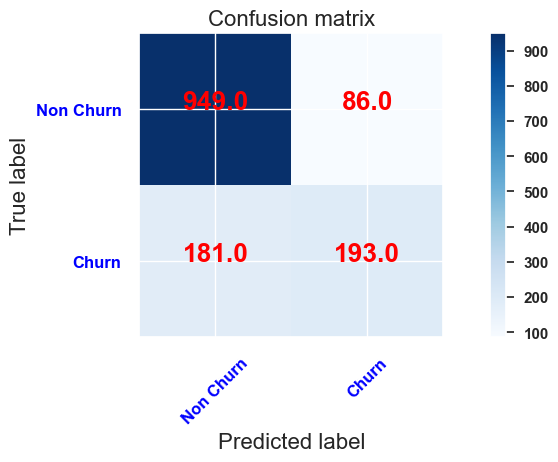

In [76]:
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):

    plt.figure(figsize=(10, 5))
    plt.rcParams.update({'font.size': 19})
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontdict={'size': '16'})
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, fontsize=12, color="blue")
    plt.yticks(tick_marks, classes, fontsize=12, color="blue")
    rc('font', weight='bold')
    fmt = '.1f'
    thresh = cm.max()
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="red")

    plt.ylabel('True label', fontdict={'size': '16'})
    plt.xlabel('Predicted label', fontdict={'size': '16'})
    plt.tight_layout()


plot_confusion_matrix(confusion_matrix(y_test, y_pred), classes=['Non Churn', 'Churn'],
                      title='Confusion matrix')

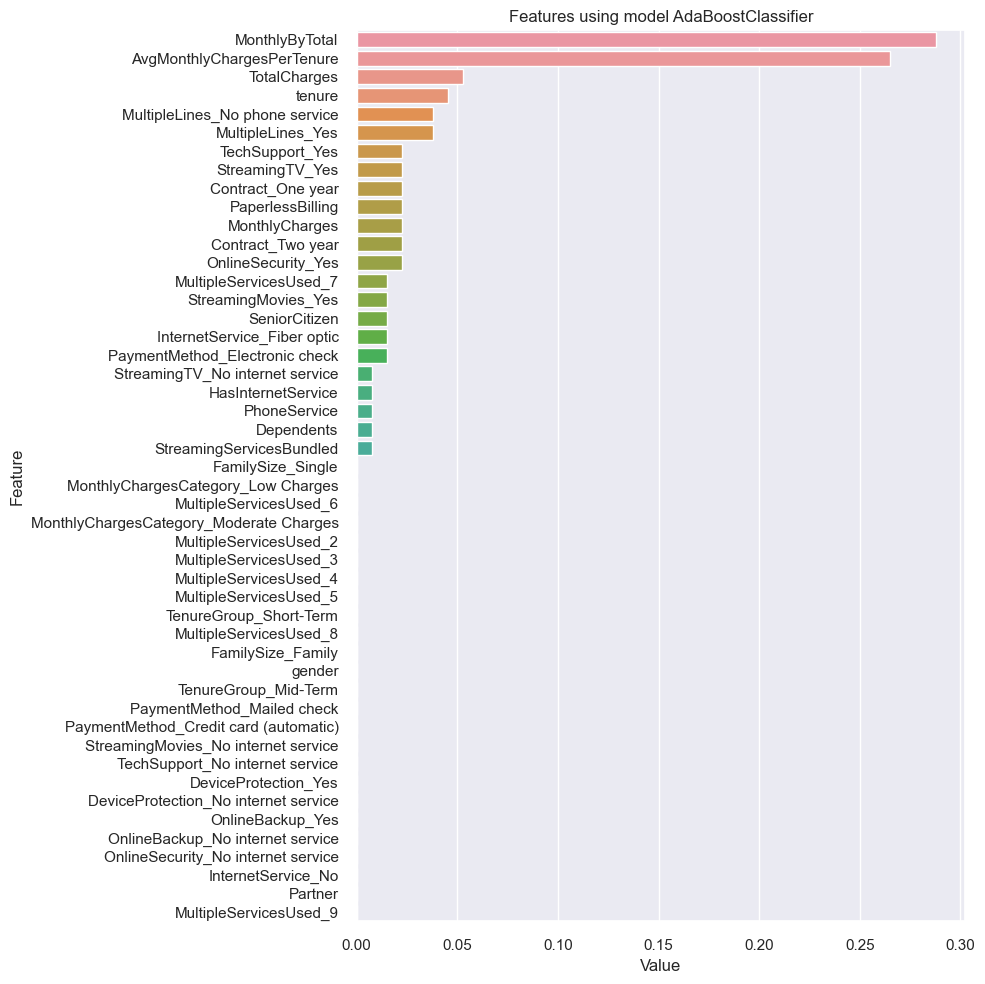

In [71]:
from sklearn.inspection import permutation_importance

def plot_importance(model, X_train, y_train, features, num=None, save=False):
    if type(model).__name__ in ['MLPClassifier', "KNeighborsClassifier"]:
        result = permutation_importance(model, X_train, y_train, n_repeats=10, random_state=0)
        feature_importances = result.importances_mean
    else:
        feature_importances = model.feature_importances_

    feature_imp = pd.DataFrame({'Value': feature_importances, 'Feature': features.columns})
    plt.figure(figsize=(10, 10))
    sns.set(font_scale=1)
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value",
                                                                    ascending=False)[:num])

    
    # viz = FeatureImportances(model).fit(X_train, y_train)
    plt.title(f'Features using model {type(model).__name__}')
    plt.tight_layout()
    plt.show()
    if save:
        plt.savefig('importances.png')
    
# Assuming you have X_train and y_train defined
plot_importance(final_model, X_train, y_train, X)


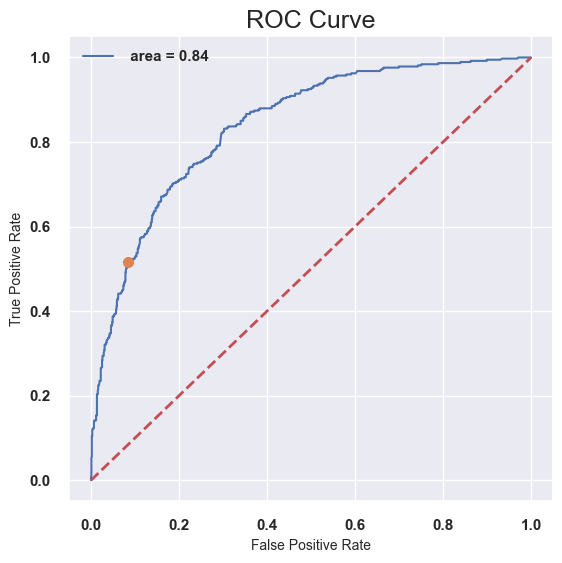

In [79]:
y_pred_prob = final_model.predict_proba(X_test)[:,1]
fig, ax = plt.subplots(figsize = (6,6))
fpr, tpr, thresholds_roc = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr,tpr)
ax.plot(fpr,tpr, label = " area = {:0.2f}".format(roc_auc))
ax.plot([0,1], [0,1], 'r', linestyle = "--", lw = 2)
ax.set_xlabel("False Positive Rate", fontsize = 10)
ax.set_ylabel("True Positive Rate", fontsize = 10)
ax.set_title("ROC Curve", fontsize = 18)
ax.legend(loc = 'best')

close_default = np.argmin(np.abs(thresholds_roc - 0.5))
ax.plot(fpr[close_default], tpr[close_default], 'o', markersize = 8)
plt.tight_layout()